# Train a MNIST neural network

The objective is to train a neural network to predict the value of a hand-written digit. The MNIST dataset consists of 60,000 training examples and 10,000 test examples of 28x28 grayscale images, representing digits 0 to 9.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

## Load the MNIST dataset

Images are converted to tensors and their pixel values are mormalized to have a mean of 0.5 and standard deviation of 0.5.

- transforms.Compose: A sequence of transformations to apply to the images.
- ToTensor(): Converts images into PyTorch tensors.
- Normalize(): Normalizes the pixel values to the range [-1, 1].
- DataLoader: DataLoader is a utility class that handles the batching, shuffling and loading of data for training and evaluation.
- batch_size=64 means that 64 samples will be processed at once.

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|███████████████████████████████| 9.91M/9.91M [00:02<00:00, 3.80MB/s]
100%|████████████████████████████████| 28.9k/28.9k [00:00<00:00, 669kB/s]
100%|███████████████████████████████| 1.65M/1.65M [00:00<00:00, 4.99MB/s]
100%|███████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.10MB/s]


In [3]:
print(f"Train dataset has {len(train_dataset)} images")
print(f"Test dataset has {len(test_dataset)} images")

Train dataset has 60000 images
Test dataset has 10000 images


In [4]:
print(f"Image shape: {train_dataset[0][0].shape}")

Image shape: torch.Size([1, 28, 28])


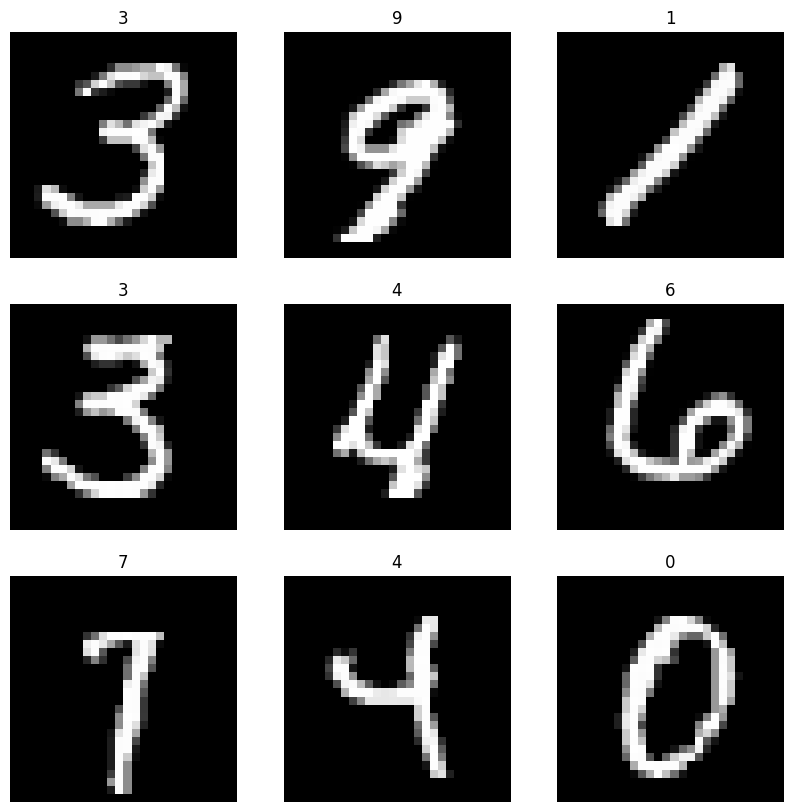

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for ax in axes.flatten():
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[sample_idx]
    ax.set_title(label)
    ax.axis('off')
    ax.imshow(image.squeeze(), cmap='gray')
plt.show()

## Build the model

This simple feedforward neural network is defined with one hidden layer. This model will take 28x28 images, flatten them and pass them through a fully connected layer followed by an output layer with 10 units (for the 10 digits).

- torch.nn.Module: The base class for all neural network modules in PyTorch. By inheriting from this class we create a custom model with layers and a forward pass.
- torch.nn.Linear: This is a basic layer where each input is connected to every output node.
- fc1: The first fully connected layer transforms the 28x28 image (flattened to a 784-length vector) into a 128-dimensional vector.
- fc2: The second fully connected layer outputs a 10-dimensional vector corresponding to the 10 possible digit classes.
- We use ReLU activation after the first layer to introduce non-linearity.

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128) 
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) 
        return x

model = Net()

## Define the Loss Function and Optimizer

- CrossEntropyLoss: Measures the difference between the predicted and true labels and is used for multi-class classification.
- Adam: A popular optimization algorithm that adapts the learning rate during training.
- lr=0.001 sets the learning rate which determines how much we adjust the weights during each update.

In [7]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model

For each epoch, complete a forward pass to compute predictions, calculate the loss, perform backpropagation to compute gradients, and update the model weights using the optimizer.

- loss.backward(): Computes gradients for each model parameter.
- optimizer.step(): Updates the model's weights using the gradients.
- cuda(): If a GPU is available we move the images, labels and model to the GPU for faster computation.
- optimizer.zero_grad(): Before performing a backward pass, set all the gradients to zero. Otherwise the gradients will accumulate from previous iterations.
- loss.backward(): This computes the gradients for the model’s weights indicating how much the weights need to be adjusted.
- optimizer.step(): This updates the model’s weights based on the gradients calculated during the backward pass.

In [8]:
train_losses = []

num_epochs = 5 
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
            model.cuda()
        else:
            model.cpu()

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if i % 200 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

    train_losses.append(running_loss / len(train_loader))

[Epoch 1, Batch 100] Loss: 0.9548
[Epoch 1, Batch 300] Loss: 0.8375
[Epoch 1, Batch 500] Loss: 0.6626
[Epoch 1, Batch 700] Loss: 0.6341
[Epoch 1, Batch 900] Loss: 0.5623
[Epoch 2, Batch 100] Loss: 0.2588
[Epoch 2, Batch 300] Loss: 0.4683
[Epoch 2, Batch 500] Loss: 0.4255
[Epoch 2, Batch 700] Loss: 0.3946
[Epoch 2, Batch 900] Loss: 0.3663
[Epoch 3, Batch 100] Loss: 0.1551
[Epoch 3, Batch 300] Loss: 0.3216
[Epoch 3, Batch 500] Loss: 0.3067
[Epoch 3, Batch 700] Loss: 0.2831
[Epoch 3, Batch 900] Loss: 0.2888
[Epoch 4, Batch 100] Loss: 0.1255
[Epoch 4, Batch 300] Loss: 0.2458
[Epoch 4, Batch 500] Loss: 0.2264
[Epoch 4, Batch 700] Loss: 0.2225
[Epoch 4, Batch 900] Loss: 0.2421
[Epoch 5, Batch 100] Loss: 0.0831
[Epoch 5, Batch 300] Loss: 0.2052
[Epoch 5, Batch 500] Loss: 0.2006
[Epoch 5, Batch 700] Loss: 0.2130
[Epoch 5, Batch 900] Loss: 0.2055


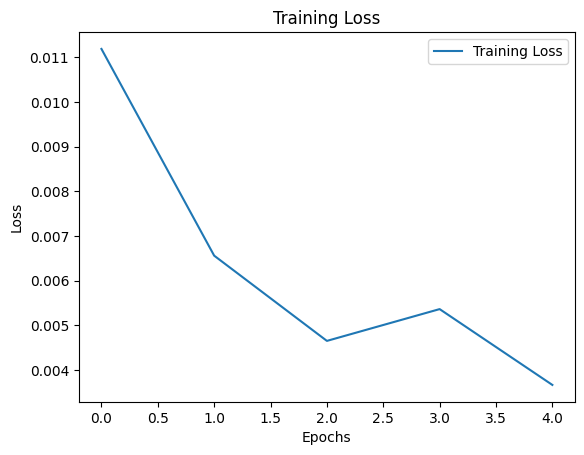

In [9]:
plt.plot(train_losses, label="Training Loss")
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate the model

Evaluate the performance of the model by computing the accuracy.

- model.eval(): Sets the model to evaluation mode disabling dropout layers.
- torch.no_grad(): Ensures that no gradients are calculated during evaluation saving memory.

In [10]:
model.eval()
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = model(images) 
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

print(f"Accuracy: {round((100 * correct / total), 3)}%")

Accuracy: 96.7%


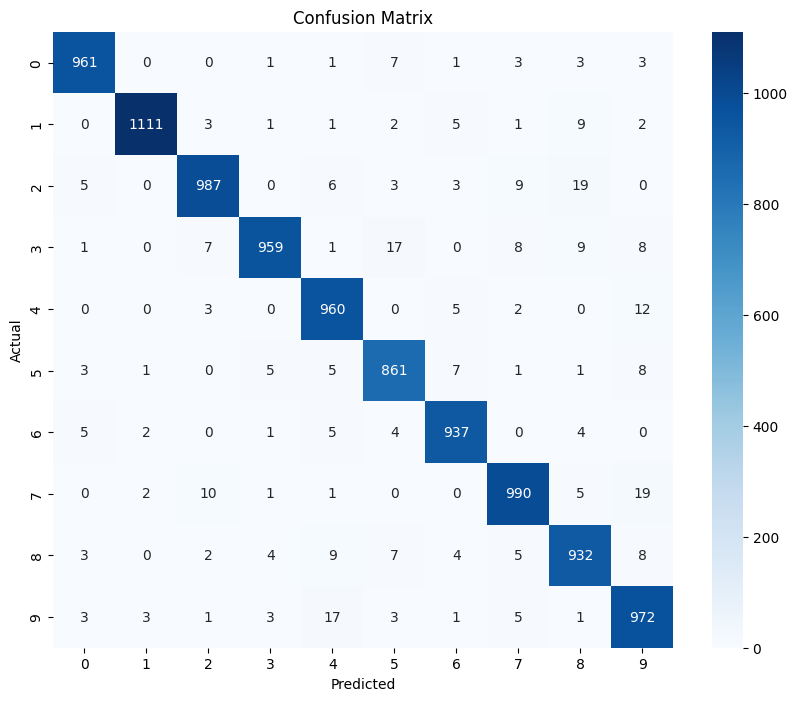

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [12]:
torch.save(model.state_dict(), 'models/mnist.pth')